# tvbl

this is a proof of concept "tvb lite" a browser-based [virtual brain](thevirtualbrain.org) Jupyter
environment.  in the workflow here, we do a simulation, then we try to recover the parameters used. 

In [1]:
%pylab inline
import time, tvbl, mdn, scipy.sparse, ipywidgets as w, tqdm, cde, models

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## different models available

22 of the TVB models are adapted for use,

In [2]:
models.test_models()

0 KIonEx  5 1 1
1 Epileptor  6 2 1
2 Epileptor2D  2 1 1
3 MontbrioPazoRoxin  2 2 1
4 CoombesByrne  4 4 1
5 CoombesByrne2D  2 2 1
6 GastSchmidtKnosche_SD  4 4 1
7 GastSchmidtKnosche_SF  4 4 1
8 DumontGutkin  8 4 1
9 JansenRit  6 2 1
10 ZetterbergJansen  12 1 1
11 LarterBreakspear  3 1 1
12 Linear  1 1 1
13 Generic2dOscillator  2 1 1
14 Kuramoto  1 1 1
15 SupHopf  2 2 1
16 WilsonCowan  2 2 1
17 ReducedWongWangExcInh  2 1 1
18 DecoBalancedExcInh  2 1 1
19 ReducedWongWang  1 1 1
20 ReducedSetFitzHughNagumo  4 2 3
21 ReducedSetHindmarshRose  6 2 3


## interactively choose a simulated ground truth

In [14]:
param_limits = dict(
    a=(1.,1.4,0.01), tau=(1.,2.,0.01), log_k=(-7.,-3.,0.01), log_z=(-1,1,0.01)
)
choices = {'params': None, 'trace': None}

@w.interact(**param_limits)
def run_plot_1(a=1.28, tau=1.35, log_k=-4.80, log_z=0.16):
    np.random.seed(42)
    
    num_item = 1
    num_node = 90
    num_skip = 1
    dt = 0.1
    sparsity = 0.3
    horizon = 256
    num_time = int(1e2/dt)
    horizonm1 = horizon - 1
    sim_params = np.r_[a, tau, np.exp(log_k)/num_node*80][:,None].astype('f')
    z_scale = np.sqrt(dt)*np.r_[0.01, 0.1].astype('f')*np.exp(log_z)
    choices['params'] = np.r_[a, tau, log_k, log_z]
    
    weights, lengths = np.random.rand(2, num_node, num_node).astype('f')
    lengths[:] *= 0.8
    lengths *= (horizon*dt*0.8)
    zero_mask = weights < (1-sparsity)
    weights[zero_mask] = 0
    csr_weights = scipy.sparse.csr_matrix(weights)
    idelays = (lengths[~zero_mask]/dt).astype('i')+2
    
    dfun = tvbl.DFun(sim_params=sim_params)
    y = tvbl.run(
        csr_weights, idelays, dfun, z_scale, horizon,
        num_item=num_item, num_node=num_node, num_time=num_time,
        dt=dt, num_skip=num_skip, show_time=False,
    )
    choices['trace'] = y
    
    figure(figsize=(8, 2));
    plot(y[:, 0, :, 0], 'k', alpha=0.2);
    grid(1); xlabel('time (ms)'); ylabel('y(t)')

    show()

interactive(children=(FloatSlider(value=1.28, description='a', max=1.4, min=1.0, step=0.01), FloatSlider(value…

In [15]:
choices['params'], param_limits

(array([ 1.28,  1.35, -4.8 ,  0.16]),
 {'a': (1.0, 1.4, 0.01),
  'tau': (1.0, 2.0, 0.01),
  'log_k': (-7.0, -3.0, 0.01),
  'log_z': (-1, 1, 0.01)})

## features

let's use simple means, variance and average fft

In [17]:
def features(trace):
    x = trace[200:, 0]
    mu = x.mean(axis=0)
    std = x.std(axis=0)
    ft = np.abs(np.fft.fft(x[-256:], axis=0).mean(axis=1))
    return np.concatenate([mu, std, ft]).astype('f')

choices['features'] = features(choices['trace'])
choices['features'].shape

(436, 1)

to know if these are useful, we should sample and look at the distribution of covariance

## Sample prior distribution

We establish a prior and a function to sample from it

In [18]:
p_lo, p_hi = np.zeros((2, 4))
for i, key in enumerate('a tau log_k log_z'.split(' ')):
    p_lo[i] = param_limits[key][0]
    p_hi[i] = param_limits[key][1]

def sample_prior(num_item):
    u = np.random.uniform(size=(p_lo.size, num_item)).T
    u *= p_hi - p_lo
    u += p_lo
    return u.T.astype('f')

sample_prior(3)

array([[ 1.0957402 ,  1.1510969 ,  1.3144447 ],
       [ 1.9382775 ,  1.943941  ,  1.0482781 ],
       [-4.2325106 , -4.0434012 , -5.3022647 ],
       [ 0.93805724, -0.57226634,  0.54184717]], dtype=float32)

## Sample prior predictive distribution

To sample the prior predictive distribution, we map each prior sample through the simulator to obtain data features.

In [25]:
sample_params = []
sample_features = []

for i_batch in tqdm.trange(num_batch := 64, ncols=79):
    num_item = 32
    num_node = 90
    num_skip = 1
    dt = 0.1
    sparsity = 0.3
    horizon = 256
    num_time = int(1e2/dt)
    horizonm1 = horizon - 1
    sim_params = sample_prior(num_item)
    sample_params.append(sim_params.copy())
    sim_params[2] = np.exp(sim_params[2])/num_node*80 # k
    z_scale = np.sqrt(dt)*np.r_[0.01, 0.1].astype('f')[:,None]*np.exp(sim_params[3])
    sim_params = sim_params[:3]  # keep z separate
    
    weights, lengths = np.random.rand(2, num_node, num_node).astype('f')
    lengths[:] *= 0.8
    lengths *= (horizon*dt*0.8)
    zero_mask = weights < (1-sparsity)
    weights[zero_mask] = 0
    csr_weights = scipy.sparse.csr_matrix(weights)
    idelays = (lengths[~zero_mask]/dt).astype('i')+2
    
    dfun = tvbl.DFun(sim_params=sim_params)
    y = tvbl.run(
        csr_weights, idelays, dfun, z_scale, horizon,
        num_item=num_item, num_node=num_node, num_time=num_time,
        dt=dt, num_skip=num_skip, show_time=False
    )

    sample_features.append(features(y))

sample_params = np.array(sample_params).transpose(1, 0, 2).reshape(-1, num_batch*num_item)
sample_features = np.array(sample_features).transpose(1, 0, 2).reshape(-1, num_batch*num_item)

100%|██████████████████████████████████████████| 64/64 [00:23<00:00,  2.77it/s]


### clean any unstable simulations

In [26]:
ok = np.isfinite(sample_features).all(axis=0)
sample_params = sample_params[:, ok]
sample_features = sample_features[:, ok]
print(f'dropped {(~ok).sum()} non finite samples, leaving {ok.sum()} samples')

dropped 0 non finite samples, leaving 2048 samples


## Train conditional density estimator

In [28]:
maf = cde.MAFEstimator(
    param_dim=sample_params.shape[0],
    feature_dim=sample_features.shape[0],
    n_flows=8,
    hidden_units=128
)

maf.train(sample_params.T, sample_features.T, n_iter=1500, learning_rate=1e-5)

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

## Apply regressor

Once training is done, inference (conditioning joint distribution on data) is *amortized* meaning it is quite fast (enabling even real time applications)

In [29]:
rng = np.random.RandomState(42)
%timeit -n50 -r5 maf.sample(choices['features'][:,0], 1000, rng)[0]
post_samples = maf.sample(choices['features'][:,0], 1000, rng)[0]

58.6 ms ± 17.3 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


## Evaluate

In this simple case, we just look at the posteriors along with the true values

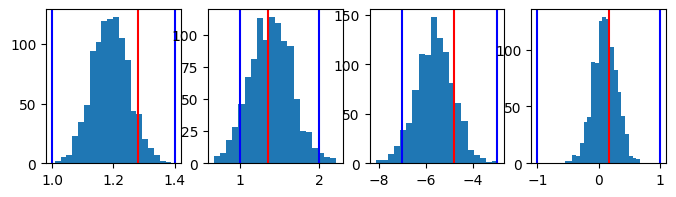

In [30]:
figure(figsize=(8,2))
for i in range(4):
    subplot(1, 4, i+1)
    axvline(p_lo[i], color='b')
    axvline(p_hi[i], color='b')
    hist(post_samples[:,i], 20)
    axvline(choices['params'][i], color='r')

we can see that the true value (in red) lies in the posterior distribution which has shrunk from the prior (blue lines).